In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from slam.gridmap import GridMap

In [3]:
plt.rcParams['figure.figsize'] = (15, 15)

c:\projects\slam-algorithms\slam\gridmap.py:157: RuntimeWarning: overflow encountered in exp
  return 1 - (1 / (1 + np.exp(l)))


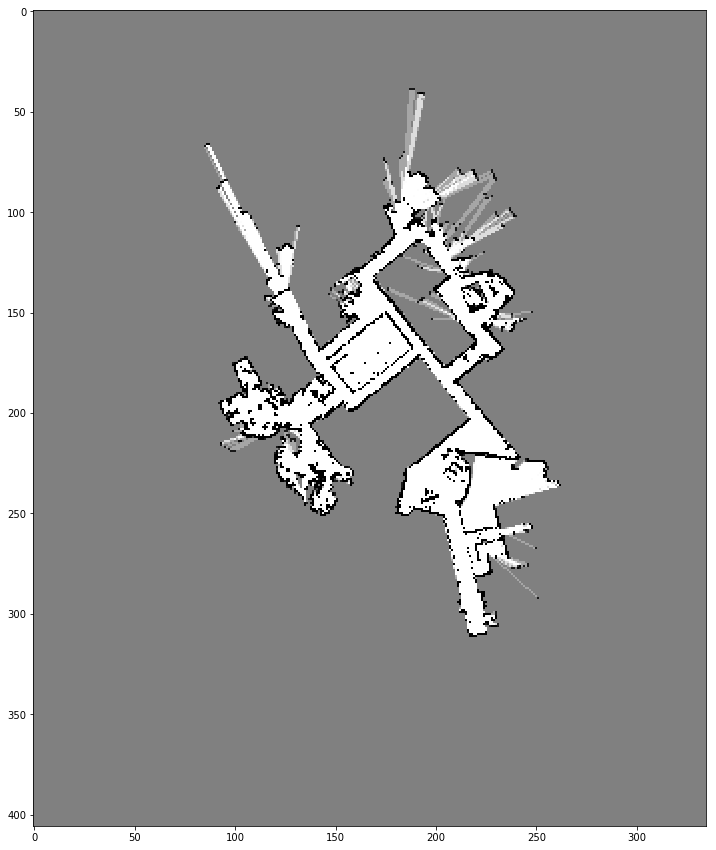

In [4]:
grid_map = GridMap('./data/laser_struct.mat', grid_size=0.3)

# Debug map
# pose_list = grid_map.get_timestep_list()[:50]
# Full map (slow)
pose_list = grid_map.get_timestep_list()
for t in pose_list:
    grid_map.update_at_timestep(t)
    
plt.imshow(grid_map.get_prob_map(), cmap='gray', interpolation='nearest')